In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from data_cleaner import *

In [2]:
df_fcu_sth_raw = pd.read_csv('data/Gnd floor FCU Sth 16032020.csv')
df_fcu_nth_raw = pd.read_csv('data/Gnd floor FCU North 16032020.csv')
df_ahu_raw = pd.read_csv('data/Gnd AHU multi list 16032020.csv')
df_chiller_boiler_raw = pd.read_csv('data/more_Data/chillers boilers thermal Feb 23032020.csv')
room_info_raw = pd.read_csv('data/Room Details.csv')

df_ltb_temps = create_temp_df(df_fcu_sth_raw, df_fcu_nth_raw, df_ahu_raw)
df_chiller_boiler_power = create_chiller_boiler_power_df(df_chiller_boiler_raw)
df_room_info = create_room_info_df(room_info_raw)

In [17]:
external_wall = df_room_info.loc[df_room_info['AHU / FCU'] == 'FCU-24']
print(df_room_info)

   Room Name  AHU / FCU  Total Area  External Wall Length
0        G31     AHU-01      544.71                 57.75
1       G01      FCU-21       97.48                 15.95
2        G02     FCU-22       88.27                  8.25
3        G03     FCU-23      240.25                 34.65
4        G21     FCU-15      161.68                  0.00
5        G23     FCU-16       91.13                  0.00
6        G81  AHU-B1-01      617.85                 51.15
7        G54  AHU-B1-02      436.09                  0.00
8        G55     FCU-09       99.10                  8.25
9        G56     FCU-08       96.22                 24.75
10       G57     FCU-07       85.67                 11.55
11       G58     FCU-06       82.24                  8.25
12       G60     FCU-04       94.06                 23.10
13       G61     FCU-02       93.05                  8.80
14       G62     FCU-01      102.02                  8.80


In [73]:
def energy_to_building(df_ltb_temps, df_room_info, freq=15):
    excluded_cols = {'OaRH','OaTmp','Timestamp', 'FCU-24'}  # Ignoring FCU-24 as it's a cooridor. Not fixed volume
    temp_cols = set([col.split(' ')[0] for col in df_ltb_temps.columns])
    AC_units = list(temp_cols.difference(excluded_cols))
    
    df_energy_received = pd.DataFrame( df_ltb_temps['Timestamp'])
    for AC_unit in AC_units:
        df_room = _energy_to_room(df_ltb_temps, df_room_info, AC_unit, freq)
        df_energy_received = pd.merge(df_energy_received, df_room, on='Timestamp')
    
    df_energy_received = df_energy_received.resample(str(freq)+'min', on='Timestamp').first().dropna()
    return df_energy_received
    
        
def _energy_to_room(df_ltb_temps, df_room_info, AC_unit, freq=15):
    U_GLASS = 2.7  # W/m²K
    CEIL_HEIGHT = 2.7
    external_wall = float(df_room_info.loc[df_room_info['AHU / FCU'] == AC_unit]['External Wall Length'])
    room_name = str(df_room_info.loc[df_room_info['AHU / FCU'] == AC_unit]['Room Name'].iloc[0])
    
    ahu_lookup = {
        'AHU-01': 'AHU-01 Internal ZnTmp_1',
        'AHU-B1-01': 'AHU-B1-01 ZnTmp_1',
        'AHU-B1-02': 'AHU-B1-02 ZnTmp_1'
    }
    if 'FCU' in AC_unit:
        delta_temp = df_ltb_temps[AC_unit + ' ZnTmp'] -  df_ltb_temps['OaTmp']
    else:
        zn_tmp = ahu_lookup[AC_unit]
        delta_temp = df_ltb_temps[zn_tmp] -  df_ltb_temps['OaTmp']
    
    delta_t = (freq * 60)  # seconds between timesteps
    ret_df = pd.DataFrame( df_ltb_temps['Timestamp'])
    incoming_watts = U_GLASS * (external_wall * CEIL_HEIGHT) * delta_temp
    ret_df[room_name] = incoming_watts * delta_t / 1000 # kJ transfered during this time period
    
    return ret_df

In [74]:
df_energy_received = energy_to_building(df_ltb_temps, df_room_info)

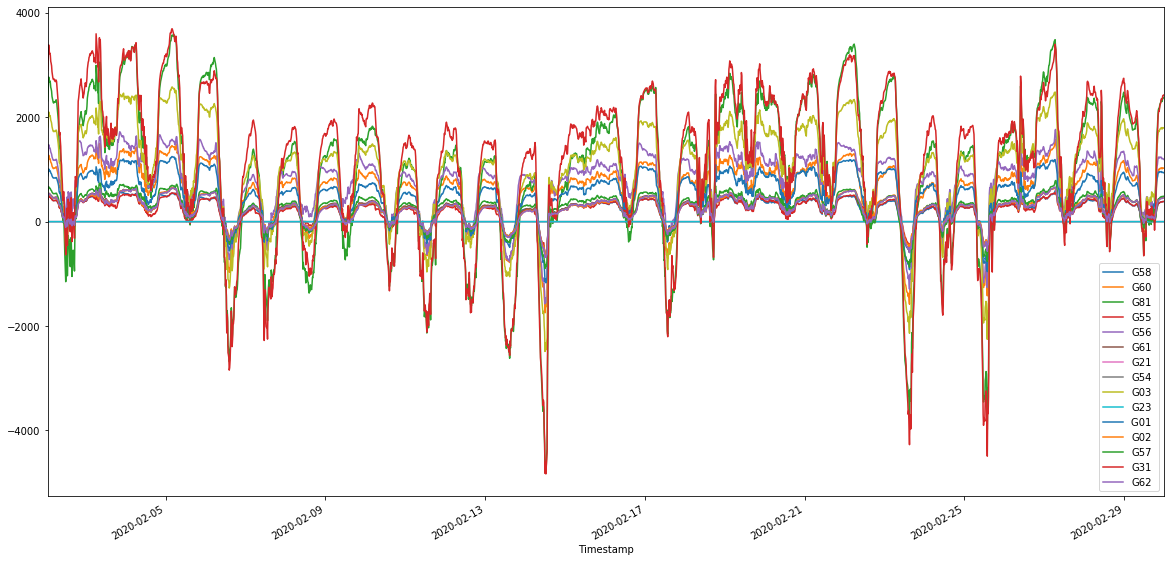

In [76]:
 # Get current axis
fig= plt.figure(figsize=(20,10))
ax = plt.gca()

for col in df_energy_received.columns:
    if col != 'Timestamp':
        df_energy_received.plot(kind='line',x='Timestamp',y=col, ax=ax)

plt.show()

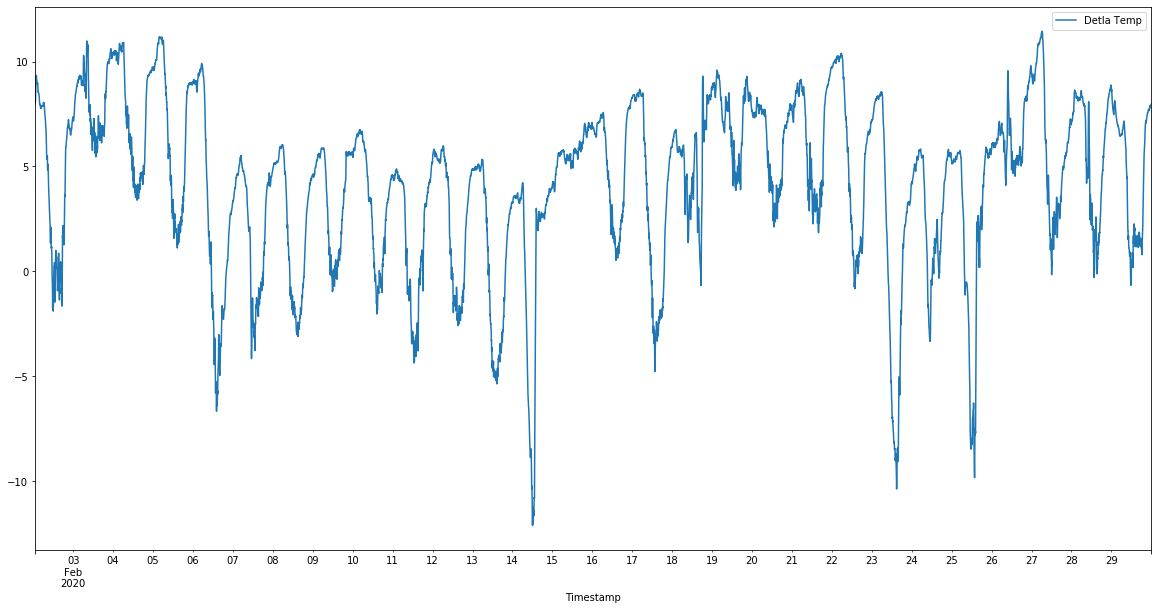

In [11]:
 # Get current axis
fig= plt.figure(figsize=(20,10))
ax = plt.gca()


df_ltb_temps.plot(kind='line',x='Timestamp',y='Detla Temp', ax=ax)


plt.show()

In [109]:
df_ltb_temps.columns
excluded_cols = {'OaRH','OaTmp','Timestamp'}
temp_cols = set([col.split(' ')[0] for col in df_ltb_temps.columns])
rooms = list(a.difference(excluded_cols))

In [39]:
sampled_ltb_temps = df_ltb_temps.resample(str(15)+'min', on='Timestamp').first().dropna()
sampled_ltb_temps[sampled_ltb_temps.Timestamp.between(start_date, end_date)]

,Timestamp,FCU-01 SaTmp,FCU-01 ZnTmp,FCU-02 SaTmp,FCU-02 ZnTmp,FCU-04 SaTmp,FCU-04 ZnTmp,FCU-06 SaTmp,FCU-06 ZnTmp,FCU-07 SaTmp,...,AHU-01 Perimeter ZnTmp_2,AHU-01 Internal SaTmp,AHU-01 Internal ZnTmp_1,AHU-B1-01 SaTmp,AHU-B1-01 ZnTmp_1,AHU-B1-01 ZnTmp_2,AHU-B1-02 SaTmp,AHU-B1-02 ZnTmp_1,AHU-B1-02 ZnTmp_2,Detla Temp
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-02-03 06:00:00,2020-02-03 06:00:00,22.98,22.67,23.15,22.89,21.95,21.79,22.02,22.06,19.31,...,22.15,19.58,21.84,21.25,21.29,22.10,20.10,22.64,22.84,8.85
2020-02-03 06:15:00,2020-02-03 06:15:00,22.95,22.66,23.18,22.90,21.95,21.85,21.82,22.06,21.19,...,22.10,19.72,21.87,18.64,21.29,22.04,19.39,22.61,22.78,10.29
2020-02-03 06:30:00,2020-02-03 06:30:00,22.83,22.65,23.11,22.88,22.34,21.80,21.96,22.09,24.34,...,21.98,20.24,21.87,18.82,21.29,21.93,18.76,22.55,22.67,9.93
2020-02-03 06:45:00,2020-02-03 06:45:00,22.72,22.64,23.01,22.88,21.94,21.73,22.13,22.18,23.91,...,21.90,21.30,21.93,19.22,21.29,21.84,18.93,22.44,22.55,9.60
2020-02-03 07:00:00,2020-02-03 07:00:00,22.71,22.63,23.02,22.87,21.79,21.71,22.28,22.15,23.70,...,21.78,20.27,21.75,19.36,21.24,21.73,17.90,22.33,22.38,9.40
2020-02-03 07:15:00,2020-02-03 07:15:00,22.70,22.63,23.12,22.88,21.78,21.72,22.28,22.14,23.19,...,21.70,19.07,21.67,19.27,21.21,21.64,18.30,22.21,22.27,8.79
2020-02-03 07:30:00,2020-02-03 07:30:00,22.71,22.63,23.09,22.89,21.62,21.74,22.18,22.17,22.72,...,21.58,20.41,21.53,19.33,21.18,21.56,19.10,22.13,22.13,8.87
2020-02-03 07:45:00,2020-02-03 07:45:00,22.68,22.63,22.95,22.89,21.68,21.74,21.86,22.18,21.97,...,21.50,20.58,21.44,19.36,21.12,21.47,17.70,22.13,22.04,8.25
2020-02-03 08:00:00,2020-02-03 08:00:00,22.78,22.66,22.60,22.97,21.41,21.75,21.82,22.19,21.87,...,21.44,19.10,21.35,18.13,21.09,21.41,17.07,22.10,21.95,10.21


In [95]:
df_ltb_temps.set_index('Timestamp').resample('15min').first().dropna()

,FCU-01 SaTmp,FCU-01 ZnTmp,FCU-02 SaTmp,FCU-02 ZnTmp,FCU-04 SaTmp,FCU-04 ZnTmp,FCU-06 SaTmp,FCU-06 ZnTmp,FCU-07 SaTmp,FCU-07 ZnTmp,...,AHU-01 Perimeter SaTmp,AHU-01 Perimeter ZnTmp_2,AHU-01 Internal SaTmp,AHU-01 Internal ZnTmp_1,AHU-B1-01 SaTmp,AHU-B1-01 ZnTmp_1,AHU-B1-01 ZnTmp_2,AHU-B1-02 SaTmp,AHU-B1-02 ZnTmp_1,AHU-B1-02 ZnTmp_2
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-02-02 01:00:00,23.12,22.79,22.22,23.02,20.74,21.93,20.41,22.66,20.10,22.34,...,20.70,22.87,20.55,22.47,21.05,21.70,22.90,20.62,22.84,22.93
2020-02-02 01:15:00,23.10,22.78,22.22,23.01,20.73,21.92,20.41,22.65,20.14,22.32,...,20.67,22.84,20.52,22.47,21.02,21.70,22.90,20.59,22.84,22.93
2020-02-02 01:30:00,23.10,22.77,22.20,23.00,20.62,21.89,20.38,22.62,20.13,22.29,...,20.67,22.81,20.47,22.44,20.93,21.70,22.90,20.50,22.87,22.96
2020-02-02 01:45:00,23.03,22.76,22.19,22.98,20.59,21.85,20.36,22.60,20.03,22.27,...,20.64,22.84,20.41,22.38,20.73,21.70,22.90,20.42,22.90,22.98
2020-02-02 02:00:00,22.87,22.73,22.15,22.93,20.63,21.76,20.29,22.57,19.93,22.23,...,20.56,22.84,20.32,22.30,20.65,21.70,22.90,20.30,22.93,23.01
2020-02-02 02:15:00,22.82,22.69,22.09,22.88,20.63,21.67,20.19,22.52,19.83,22.18,...,20.47,22.81,20.21,22.24,20.56,21.70,22.90,20.25,22.93,23.04
2020-02-02 02:30:00,22.79,22.64,22.02,22.84,20.46,21.61,20.08,22.47,19.69,22.13,...,20.38,22.78,20.10,22.18,20.53,21.70,22.90,20.25,22.95,23.07
2020-02-02 02:45:00,22.80,22.60,21.97,22.81,20.40,21.57,19.99,22.42,19.52,22.07,...,20.30,22.73,20.01,22.15,20.50,21.67,22.90,20.22,22.95,23.07
2020-02-02 03:00:00,22.79,22.57,21.94,22.79,20.55,21.52,19.93,22.38,19.57,22.02,...,20.21,22.70,19.92,22.10,20.50,21.67,22.87,20.22,22.95,23.07


In [86]:
df_ltb_temps

,Timestamp,FCU-01 SaTmp,FCU-01 ZnTmp,FCU-02 SaTmp,FCU-02 ZnTmp,FCU-04 SaTmp,FCU-04 ZnTmp,FCU-06 SaTmp,FCU-06 ZnTmp,FCU-07 SaTmp,...,AHU-01 Perimeter SaTmp,AHU-01 Perimeter ZnTmp_2,AHU-01 Internal SaTmp,AHU-01 Internal ZnTmp_1,AHU-B1-01 SaTmp,AHU-B1-01 ZnTmp_1,AHU-B1-01 ZnTmp_2,AHU-B1-02 SaTmp,AHU-B1-02 ZnTmp_1,AHU-B1-02 ZnTmp_2
4415,2020-02-29 23:55:00,22.85,22.52,22.03,22.70,20.91,21.39,20.45,21.74,20.11,...,20.07,21.04,19.64,21.04,20.10,21.72,22.70,19.56,22.50,22.64
4416,2020-02-29 23:50:00,22.87,22.53,22.03,22.71,21.15,21.41,20.48,21.76,20.14,...,20.10,21.07,19.67,21.07,20.10,21.75,22.73,19.56,22.50,22.64
4417,2020-02-29 23:45:00,22.87,22.54,22.04,22.72,21.18,21.43,20.49,21.77,20.13,...,20.10,21.07,19.70,21.07,20.13,21.75,22.73,19.59,22.50,22.64
4418,2020-02-29 23:40:00,22.89,22.55,22.04,22.74,20.99,21.45,20.51,21.79,20.35,...,20.13,21.07,19.70,21.07,20.13,21.75,22.73,19.62,22.50,22.64
4419,2020-02-29 23:35:00,22.90,22.56,22.05,22.75,21.07,21.47,20.54,21.81,20.22,...,20.13,21.10,19.72,21.10,20.13,21.78,22.76,19.65,22.50,22.64
4420,2020-02-29 23:30:00,22.92,22.57,22.06,22.76,21.00,21.49,20.56,21.82,20.23,...,20.16,21.10,19.72,21.10,20.16,21.78,22.76,19.65,22.50,22.64
4421,2020-02-29 23:25:00,22.93,22.58,22.06,22.77,21.23,21.52,20.57,21.84,20.27,...,20.16,21.13,19.75,21.10,20.16,21.78,22.76,19.67,22.50,22.64
4422,2020-02-29 23:20:00,22.94,22.59,22.07,22.78,21.09,21.54,20.60,21.86,20.29,...,20.16,21.13,19.75,21.13,20.19,21.81,22.81,19.70,22.50,22.64
4423,2020-02-29 23:15:00,22.95,22.60,22.08,22.79,21.12,21.56,20.62,21.88,20.34,...,20.18,21.13,19.78,21.13,20.19,21.81,22.81,19.70,22.50,22.64
4424,2020-02-29 23:10:00,22.97,22.61,22.08,22.80,21.22,21.58,20.65,21.89,20.46,...,20.18,21.15,19.78,21.13,20.19,21.81,22.81,19.70,22.50,22.64


In [61]:
sampling(df_chiller_boiler_power, '15T')

KeyError: "None of [Int64Index([0], dtype='int64')] are in the [index]"

In [30]:
sampling(df_ltb_temps, '10T')

KeyError: 4415

## Testing

In [22]:
sampling(df_ltb_temps, '10M')

[0]


KeyError: "None of [Int64Index([0], dtype='int64')] are in the [index]"

# Showing external temps

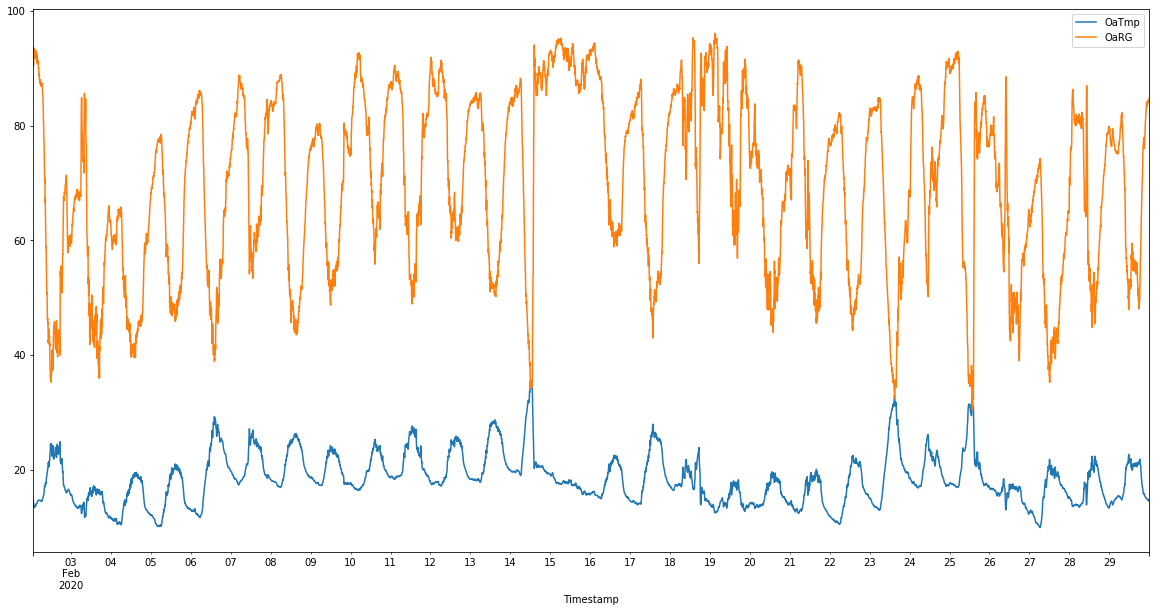

In [10]:
 # Get current axis
fig= plt.figure(figsize=(20,10))
ax = plt.gca()

counter = 0
for col in df_ltb_temps.columns:
    if col != 'Timestamp' and ('Oa' in col):
        df_ltb_temps.plot(kind='line',x='Timestamp',y=col, ax=ax)
    counter += 1

plt.show()